In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

#! pip install tensorflow
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# import norm
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display


import os
from os import listdir
from os.path import isfile, join
import pickle
import random
#importing module
import sys
sys.path.insert(0, '../data')
from datahandler_multilabel import create_dataset

from PIL import ImageFile, Image

In [2]:
with open('../data/train_test_split.pkl', 'rb') as infile:
    train_x, train_y, val_x, val_y, test_x, test_y = pickle.load(infile)

len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y)

(18000, 18000, 3000, 3000, 3999, 3999)

In [3]:
model = tf.keras.models.load_model('./results/training_flat_multilabel_VGGfine_tuned.h5', compile=False)

In [4]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

def mean_per_class_accuracy(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    per_class_acc = []
    per_class_acc.append(tf.cast(tf.math.count_nonzero(y_pred[i] * y[i], axis=0), tf.float32))
    mean_acc = tf.reduce_mean(per_class_acc)
    return mean_acc

def precision(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    pres = tp / (tp + fp + 1e-16)
    precision = tf.reduce_mean(pres)
    return precision

def recall(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    rec = tp / (tp + fn + 1e-16)
    recall = tf.reduce_mean(rec)
    return recall

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       precision,
                       recall,
                       macro_f1
                      ])

In [6]:
train_generator = create_dataset(train_x, train_y)
val_generator = create_dataset(val_x, val_y)
test_generator = create_dataset(test_x, test_y)

In [ ]:
model.evaluate(train_generator, verbose=2)

In [ ]:
model.evaluate(val_generator, verbose=2)

In [ ]:
model.evaluate(test_generator, verbose=2)

In [7]:
pred = model.predict_generator(test_generator, verbose=1)

72/72 [==============================] - 1811s 25s/step


In [ ]:
pred = model.predict_generator(train_generator, verbose=1)

169/322 [==============>...............] - ETA: 1:14:53

In [ ]:
predicted_train_indices = np.where(pred > 0.5, 1, 0)
print(predicted_train_indices)

In [8]:
predicted_class_indices = np.where(pred > 0.5, 1, 0)
print(predicted_class_indices)

[[0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 1 0]]


In [7]:
def mean_per_class_accuracy(y, y_hat, num_classes):
    accuracy = [0]*num_classes
    for i in range(num_classes):
        accuracy[i] = 0
        for j in range(len(y)):
            if y[j][i] == y_hat[j][i]:
                accuracy[i] += 1
        accuracy[i] /= len(y)
    return accuracy

def mean_per_item_accuracy(y, y_hat, num_classes):
    accuracy = [0]*len(y)
    for i in range(len(y)):
        accuracy[i] = 0
        for j in range(num_classes):
            if y[i][j] == y_hat[i][j]:
                accuracy[i] += 1
        accuracy[i] /= num_classes
    return sum(accuracy)/len(y)


In [12]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices, 16
)
per_class_accuracy, sum(per_class_accuracy)/16

([0.5036259064766192,
  0.5493873468367092,
  0.6111527881970492,
  0.5591397849462365,
  0.584896224056014,
  0.6284071017754439,
  0.498624656164041,
  0.6676669167291823,
  0.8907226806701676,
  0.8027006751687922,
  0.8739684921230307,
  0.9004751187796949,
  0.9087271817954489,
  0.9402350587646912,
  0.9072268067016754,
  1.0],
 0.7391847961990498)

In [13]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 16
)
per_item_accuracy

0.7391847961990498

In [68]:
conf_matrix = multilabel_confusion_matrix(test_y, predicted_class_indices)
conf_matrix

array([[[ 822,  924],
        [1061, 1192]],

       [[1753,  744],
        [1058,  444]],

       [[2188,  732],
        [ 823,  256]],

       [[1801,  865],
        [ 898,  435]],

       [[1995,  851],
        [ 809,  344]],

       [[2304,  489],
        [ 997,  209]],

       [[1081,  900],
        [1105,  913]],

       [[2517,  473],
        [ 856,  153]],

       [[3551,  170],
        [ 267,   11]],

       [[3187,  160],
        [ 629,   23]],

       [[3488,  130],
        [ 374,    7]],

       [[3590,   92],
        [ 306,   11]],

       [[3631,   19],
        [ 346,    3]],

       [[3760,   25],
        [ 214,    0]],

       [[3625,   91],
        [ 280,    3]],

       [[3999,    0],
        [   0,    0]]], dtype=int64)

In [ ]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n', sum(precision[:15])/15, '\n', sum(recall[:15])/15, '\n', sum(f1[:15])/15)

In [25]:
labels_dict = {0:'people',1:'objects',2:'places',3:'architecture',4:'abstraction',5:'society',\
          6:'nature',7:'emotions, concepts and ideas',8:'interiors',9:'work and occupations', \
          10:'symbols & personifications',11:'religion and belief',12:'leisure and pastimes',\
          13:'history',14:'literature and fiction',15:'group/movement'}
predictions = [[]]*len(predicted_class_indices)
actual = [[]]*len(test_y)
for k in range(len(predicted_class_indices)):
    predictions[k] = []
    actual[k] = []
    for i in range(len(predicted_class_indices[k])):
        if predicted_class_indices[k][i] == 1:
            predictions[k].append(labels_dict[i])
        if test_y[k][i] == 1:
            actual[k].append(labels_dict[i])
            
print(len(predictions), len(actual))

3999 3999


In [26]:
results=pd.DataFrame({"Filename":test_x,
                      "Actual":actual,
                      "Predictions":predictions})
results.to_csv("./results/results_vgg_finetuning.csv",index=False)

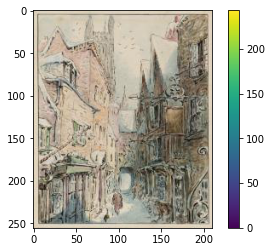

predicted as: ['people', 'abstraction'] 
actual class: ['people', 'places', 'architecture', 'nature', 'literature and fiction']


In [10]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results.csv")
img  = Image.open(str(results.Filename[number]))
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

In [27]:
import torch
from CNN_RNN.model_attention import DecoderRNN
model = DecoderRNN(512, 1024, 19, 1).to('cpu')
checkpoint = torch.load('./results/decoder-5-600.ckpt', map_location=torch.device('cpu'))
print(checkpoint.keys())
model.load_state_dict(checkpoint)
model.eval()

odict_keys(['att_bias', 'embed.weight', 'lstm_cell.weight_ih', 'lstm_cell.weight_hh', 'lstm_cell.bias_ih', 'lstm_cell.bias_hh', 'linear.weight', 'linear.bias', 'att_vw.weight', 'att_hw.weight', 'att_w.weight'])


DecoderRNN(
  (embed): Embedding(19, 512)
  (lstm_cell): LSTMCell(1024, 1024)
  (linear): Linear(in_features=1024, out_features=19, bias=True)
  (att_vw): Linear(in_features=512, out_features=512, bias=False)
  (att_hw): Linear(in_features=1024, out_features=512, bias=False)
  (att_w): Linear(in_features=512, out_features=1, bias=False)
)

In [ ]:
import torch

with open('./results/predictions_CNN_RNN.pkl', 'rb') as infile:
    predictions = torch.load(infile, map_location=torch.device('cpu'))
    
predictions